In [1]:
from credit.data import get_forward_data
from glob import glob
import os
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from os.path import join
from credit.xr_sampler import XRSamplerByYear
import yaml


#### debug option

In [ ]:
# rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/skebs_diss_train"
# rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/skebs_fcnn_scaled_train/forecast"
# rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/skebs_fcnn_12_24h"
# rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/conv_12h_skebs"
# rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/skebs_fcnn_24h/forecast"
# rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/fcnn_36h_skebs/forecast"
rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/fcnn_12h_train_a_filter/forecast"
rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/fcnn_6_12h_train_filter/forecast"
# # eval_fh = 6
# std_files_test = glob(join(rollout_dir, f"ens_std_2012*/*{eval_fh:03}.nc")) + glob(join(rollout_dir, f"ens_std_2013*/*{eval_fh:03}.nc"))



## define metrics

### spread-error



In [3]:
def open_and_concat(files):
    ds_list = [xr.open_dataset(file) for file in files]
    return xr.concat(ds_list, dim='time')

In [4]:
def spread_error_binned(variable, level, bins, files):
    std_file, err_file = files[0], files[1]
    std, err = xr.open_dataset(std_file), xr.open_dataset(err_file)

    
    assert std.time.values[0] == err.time.values[0]
    assert len(std.time.values) == 1
    assert len(err.time.values) == 1
    
    
    n_bins = len(bins) + 1
    spread_flat = std[variable].isel(level=level).values.flatten()
    error_flat = err[variable].isel(level=level).values.flatten()
    
    bin_indices = np.digitize(spread_flat, bins) - 1
    
    # bin_indices = np.clip(bin_indices, 0, n_bins-1)  # Ensure within bounds
    
    # Calculate mean spread and RMSE for each bin
    mean_spread = np.zeros(n_bins)
    mean_error = np.zeros(n_bins)
    count = np.zeros(n_bins)
    
    for i in range(n_bins):
        mask = bin_indices == i
        if np.sum(mask) > 0:
            mean_spread[i] = np.mean(spread_flat[mask])
            mean_error[i] = np.mean(error_flat[mask])
            count[i] = np.sum(mask)
    return mean_spread, mean_error, count, bins
    

    

# run metrics

In [5]:
import multiprocessing
from functools import partial

In [6]:
variable, level = "U", 24 #np.arange(32)
bins = np.arange(0, 10, 0.25)
results = {}

f = partial(spread_error_binned, variable, level, bins)
forecast_hours = [48, 72, 120, 240]
for eval_fh in forecast_hours:  
    with multiprocessing.Pool(8) as p:
        std_files = glob(join(rollout_dir, f"ens_std_2012*/*{eval_fh:03}.nc")) + glob(join(rollout_dir, f"ens_std_2013*/*{eval_fh:03}.nc"))
        err_files = glob(join(rollout_dir, f"ens_rmse_2012*/*{eval_fh:03}.nc")) + glob(join(rollout_dir, f"ens_rmse_2013*/*{eval_fh:03}.nc"))
        std_files.sort()
        err_files.sort()
        result = p.map(f, zip(std_files, err_files))
    results[eval_fh] = result

In [21]:
# post_process
post_processed = {}
for eval_fh, result in results.items():
    count = result[0][2]
    sum_count = count
    spread = result[0][0] * count
    error = result[0][1] * count

    for res in result[1:]:
        sum_count += res[2]
        spread += res[0] * count
        error += res[1] * count
    non_neg_mask = sum_count > 0.
    spread = spread[non_neg_mask] / sum_count[non_neg_mask]
    error = error[non_neg_mask] / sum_count[non_neg_mask]
    post_processed[eval_fh] = {'spread': spread,
                               'error': error}
    

In [22]:
sum_count[non_neg_mask]

array([2.16000e+02, 2.03000e+03, 8.66200e+03, 2.75420e+04, 5.89390e+04,
       1.13110e+05, 1.77013e+05, 2.38636e+05, 2.98642e+05, 3.52305e+05,
       3.88866e+05, 4.11367e+05, 4.24011e+05, 4.18656e+05, 4.09839e+05,
       3.87657e+05, 3.68997e+05, 3.42215e+05, 3.17671e+05, 2.87096e+05,
       2.62526e+05, 2.33696e+05, 2.08053e+05, 1.84931e+05, 1.62248e+05,
       1.42465e+05, 1.24724e+05, 1.06792e+05, 9.38380e+04, 8.17710e+04,
       6.99980e+04, 5.91450e+04, 5.02050e+04, 4.08430e+04, 3.36200e+04,
       2.83850e+04, 1.05882e+05])

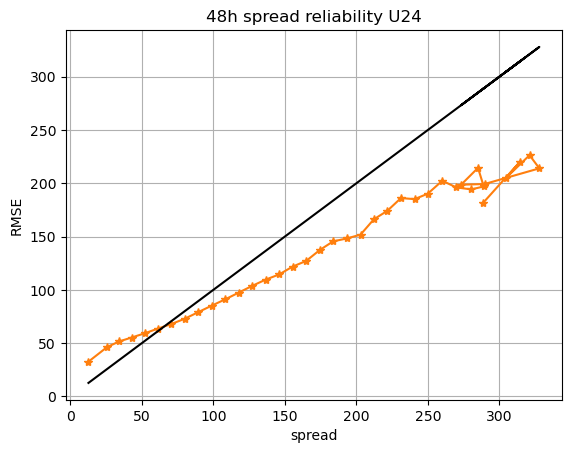

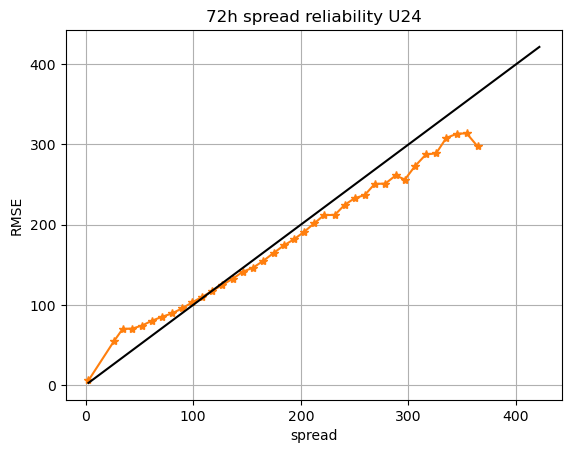

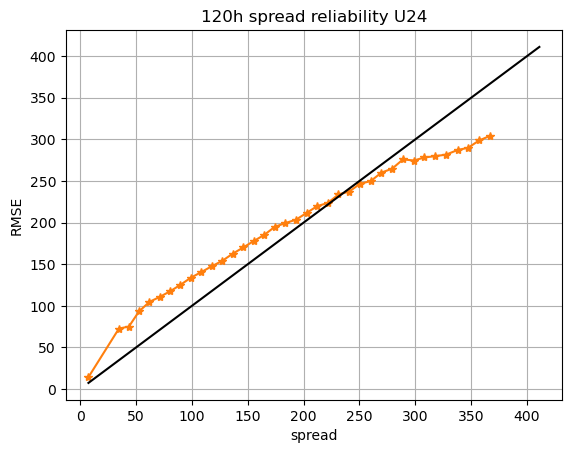

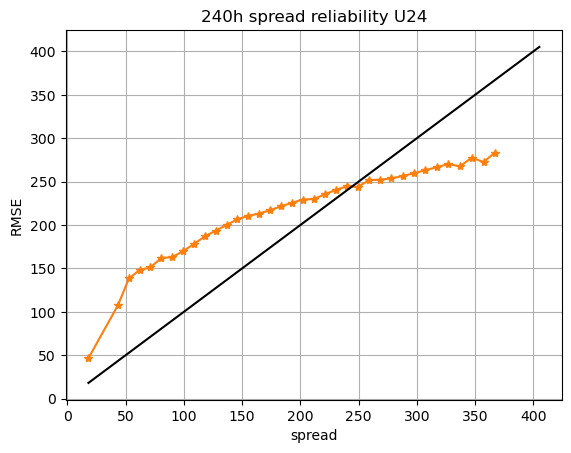

In [23]:
for eval_fh, result in post_processed.items(): 
    spread = result['spread']
    error = result['error']

    plt.plot(spread[:-1], error[:-1], c = 'tab:orange', marker="*")
    plt.plot(spread, spread, c='0')
    plt.xlabel("spread")
    plt.ylabel("RMSE")
    plt.title(f"{eval_fh}h spread reliability {variable}{level}")
    plt.grid(True)
    plt.show()

In [10]:
# n/s extra tropics and tropics

In [11]:
error = result[0][1]
error_lat = error.mean(dim="longitude")    
for _, error in result[1:]:
    error_lat += error.mean(dim="longitude")

error = error_lat / len(result)


KeyError: 0

n_std, n_error = [], []
t_std, t_error = [], []
s_std, s_error = [], []

for res in result:
    std, error = res
    # std, error = std.mean(dim="longitude"), error.mean(dim="longitude")
    # n extratropics
    n_std.append(std.sel(latitude=slice(24,91)).mean().values)
    n_error.append(error.sel(latitude=slice(24,91)).mean().values)
    # tropics
    t_std.append(std.sel(latitude=slice(-24,24)).mean().values)
    t_error.append(error.sel(latitude=slice(-24,24)).mean().values)
    # s extra tropics
    s_std.append(std.sel(latitude=slice(-91,-24)).mean().values)
    s_error.append(error.sel(latitude=slice(-91,-24)).mean().values)
    

forecast_day = 6 * (np.arange(len(result)) + 1) / 24
def plot(std, error, label=None):
    plt.plot(forecast_day, std, label="std", c='tab:orange')
    plt.plot(forecast_day, error, label="rmse", c='b')
    plt.xlabel("Day")
    plt.title(f"{variable}{level if variable in 'UVTQtot' else ''} {label} Spread-Error")
    plt.legend()
    plt.grid(True)
    plt.show()

plot(n_std, n_error, "N extratropics")

plot(t_std, t_error, "Tropics")

plot(s_std, s_error, "S extratropics")